<a href="https://colab.research.google.com/github/afrojaakter/Pattern-Recognition/blob/main/RobustRegression%26%26Lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Least-Square regression Vs L1-norm:

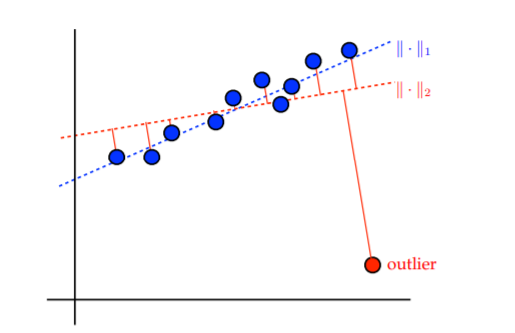

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import minimize
from sklearn import linear_model
from sklearn import model_selection

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

In [2]:
x = np.sort(4*(np.random.rand(25,1)-0.5),axis=0) # Random data from [-2,2]
b = 0.9*x + 0.1*np.random.randn(len(x),1)  # Line y = 0.9x with noise
atrue = np.linalg.lstsq(x,b,rcond=None)[0] # Least-squares slope (no outliers)
atrue = atrue.item(0)

b[-1] = -5.5  # Introduce outlier
acorrupt = np.linalg.lstsq(x,b,rcond=None)[0] # New slope
acorrupt = acorrupt.item(0)

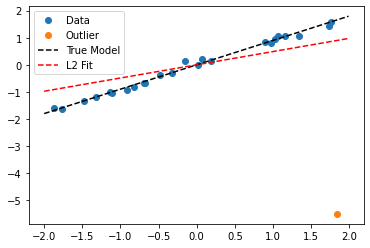

In [3]:
plt.plot(x[:-1], b[:-1], 'o', label = 'Data') #data
plt.plot(x[-1], b[-1], 'o', label = 'Outlier') #outlier
xgrid = np.arange(-2,2,0.01)
plt.plot(xgrid,atrue*xgrid,'--',color='k', label = 'True Model')    #True Model
plt.plot(xgrid,acorrupt*xgrid,'--',color='r', label = 'L2 Fit') # L2 fit
plt.legend()
plt.show()


In [4]:
## L1 optimization to reject outlier
def L1_norm(a):
    return np.linalg.norm(a*x-b,ord=1)

a0 = acorrupt   # initialize to L2 solution
res = minimize(L1_norm, a0) # minimization optimizer
aL1 = res.x[0]  # aL1 is robust

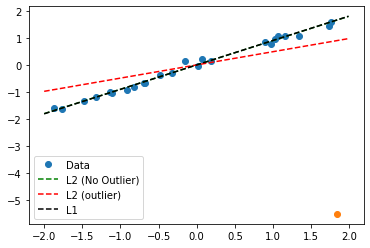

In [5]:
plt.plot(x[:-1],b[:-1],'o', label = 'Data') # Data
plt.plot(x[-1],b[-1],'o')   # Outlier

xgrid = np.arange(-2,2,0.01)
plt.plot(xgrid,atrue*xgrid,'--',color='g', label = 'L2 (No Outlier)')    # L2 fit (no outlier)
plt.plot(xgrid,acorrupt*xgrid,'--',color='r', label = 'L2 (outlier)') # L2 fit (outlier)
plt.plot(xgrid, aL1*xgrid,'--',color='k', label = 'L1')      # L1 fit
plt.legend()
plt.show()

####Lasso
Optimization objective for Lasso is:

  $$\frac{1}{2n} ||b - Ax||^2_2 + \alpha ||x||_1$$ 

where n is the number of samples

####Cross Validation

The following procedure is followed for each of the k “folds”:

- A model is trained using $k-1$  of the folds as training data;

- The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

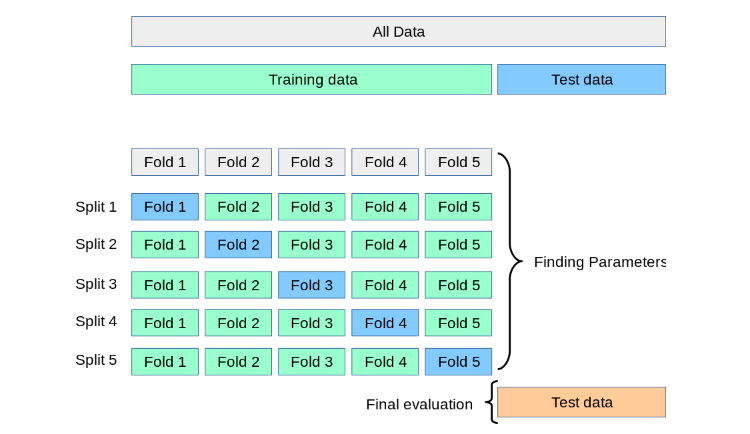

In [35]:
A = np.random.randn(1000,10) # Matrix of possible predictors
x = np.array([0, 0, 1, 0, 0, 0, -1, 0, 0, 0]) #Two nonzero predictors
b = A @ x + 0.5*np.random.randn(1000) # Ax + noise

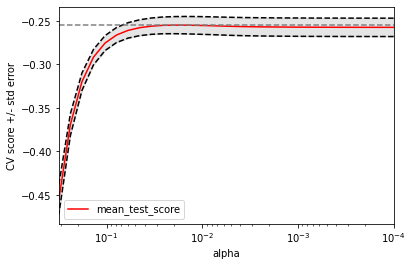

In [46]:
from sklearn.metrics import mean_squared_error
#Lasso: Linear Model trained with L1 prior as regularizer 
lasso = linear_model.Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30) # numbers spaced evenly on a log scale

tuned_parameters = [{'alpha': alphas}] #a list of dictionary

# GridSearch: Exhaustive search over specified parameter values for an estimator.
clf = model_selection.GridSearchCV(lasso, tuned_parameters, cv=10, refit=False, scoring = 'neg_mean_squared_error')
clf.fit(A, b)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.semilogx(alphas, scores,'r-', label = 'mean_test_score')
# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(10)

plt.semilogx(alphas, scores + std_error, 'k--')
plt.semilogx(alphas, scores - std_error, 'k--')
plt.fill_between(alphas, scores + std_error, scores - std_error, 
                 alpha=0.1,color='k')

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[-1], alphas[0]])
plt.legend()
plt.show()

In [42]:
xL2 = np.linalg.pinv(A) @ b #pseudo inverse
XL1 = linear_model.Lasso(alpha=clf.best_params_['alpha'])
XL1.fit(A,b)
xL1 = XL1.coef_
xL1DeBiased = np.linalg.pinv(A[:,np.abs(xL1)>0]) @ b
print('x: {} \n\nxL2: {} \n\nxL1: {}\n\nxL1DeBiased: {}'.format(x, xL2, xL1, xL1DeBiased))

x: [ 0  0  1  0  0  0 -1  0  0  0] 

xL2: [ 0.00588867 -0.01598367  0.99338996  0.00380213  0.01758425  0.00299127
 -1.0097203   0.00445048  0.00780244 -0.01465155] 

xL1: [ 0.         -0.          0.97518562  0.          0.          0.
 -0.98891938  0.          0.         -0.        ]

xL1DeBiased: [ 0.99364042 -1.00867374]


In [21]:
clf.best_params_['alpha']

0.0196382800192977